## Sandbox for adversarial examples

Modify freely...

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import mnist_stuff as ms
import time

import torchvision as tv
import torchvision.utils as utils
from IPython import display
#%config Completer.use_jedi = False

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./data/lenet_mnist_model.pth"
use_cuda=True

In [3]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)


In [4]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [5]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

In [6]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [8]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [25]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8509 / 10000 = 0.8509
Epsilon: 0.15	Test Accuracy = 6828 / 10000 = 0.6828
Epsilon: 0.2	Test Accuracy = 4302 / 10000 = 0.4302
Epsilon: 0.25	Test Accuracy = 2081 / 10000 = 0.2081
Epsilon: 0.3	Test Accuracy = 871 / 10000 = 0.0871


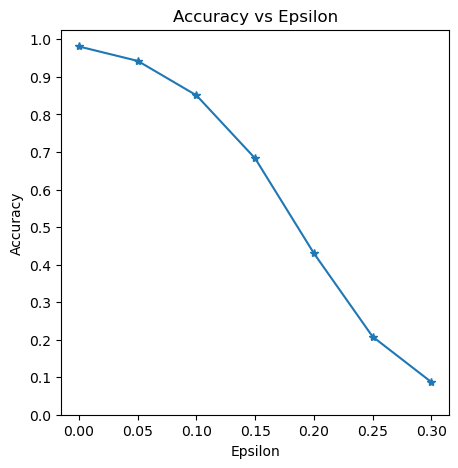

In [27]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

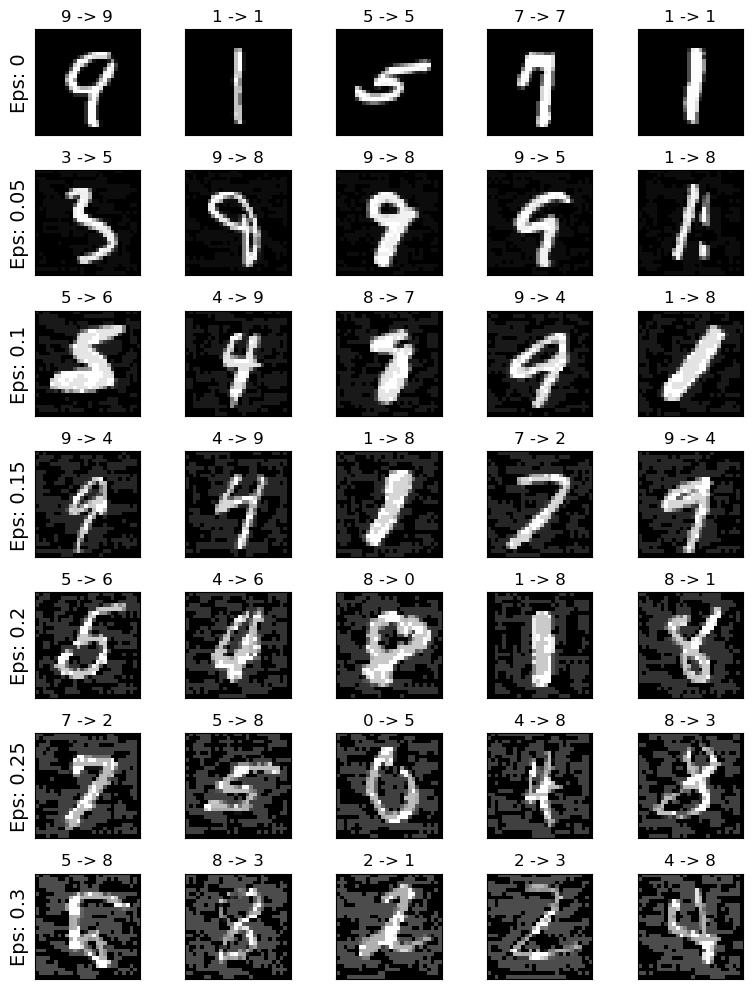

In [28]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### Some additional testing options

In [69]:
#helper
def conv_dims(d_in, k=1, p=0, s=1):
    return int((d_in + 2*p - k)/s + 1)

(You can use these as base models)

In [70]:
class VGGBlock(nn.Module):
    def __init__(self, layers, in_channels, out_channels, k_size=1, padding = 0, stride=1):
        super(VGGBlock,self).__init__()
        
        l =[]
        for i in range(layers):
            l.append(nn.Sequential(nn.Conv2d(in_channels,out_channels,k_size,padding=padding,stride=stride),\
                          nn.BatchNorm2d(out_channels),nn.ReLU()))
            if in_channels!=out_channels:
                in_channels=out_channels
        
        self.block = nn.Sequential(*l)
    
    def forward(self,x):
        return self.block(x)


class VGGNet(nn.Module):
    def __init__(self, n_channels=16):
        
        super(VGGNet, self).__init__()
        self.block1 = VGGBlock(3,1,n_channels,3,1)
        self.block2 = VGGBlock(3,n_channels,2*n_channels,3,1)
        self.block3 = VGGBlock(1,2*n_channels,3*n_channels,3)
        self.block4 = VGGBlock(1,3*n_channels,2*n_channels,1)
        self.block5 = VGGBlock(1,2*n_channels,n_channels,1)
        self.gap = nn.AvgPool2d(5)
        self.fc = nn.Linear(16,10)

    def forward(self, x):
        
        x = self.block1(x)
        x = F.max_pool2d(x,2,2)
        x = self.block2(x)
        x = F.max_pool2d(x,2,2)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.gap(x)
        x = x.view(-1,16)
        
        return self.fc(x)
        
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(1,16,5)
        self.conv2 = nn.Conv2d(16,32,5)
        self.fc1 = nn.Linear(32*4*4,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        
        bat = x.shape[0]
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2),stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2),stride=2)
        x = x.view(bat,-1)#,32*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return self.fc3(x)

In [ ]:
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(model, train_loader, test_loader, loss_fn, optimizer, epochs):
    for i in range(epochs):
        model.train()
                
        for images,labels in train_loader:
            images, labels = images.to(device), labels.to(device)
                
            yhat = model(images)
            loss = loss_fn(yhat,labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
        print(compute_accuracy(model, test_loader))

In [ ]:
# FGSM attack code
#@torch.jit.script
def fgsm_attack(image, epsilon: float, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    
    return perturbed_image

In [ ]:
# MI_FGSM attack code
#@torch.jit.script
def MI_FGSM_step(image, epsilon: float, data_grad, mu: float, g):
    g_new = mu*g + data_grad / torch.norm(data_grad, p=1)
    perturbed_image = image + epsilon*g_new.sign()
    
    return perturbed_image, g_new

In [ ]:
# Define some data loaders

breaktransforms: tv.transforms.Compose = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5], [0.5])])


train_set = tv.datasets.MNIST("./data/", train=True, transform=transforms, download=False)
tr_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True, num_workers=6)


test_set = tv.datasets.MNIST("./data/", train=False, transform=transforms, download=False)
ts_loader = torch.utils.data.DataLoader(test_set, batch_size=32, pin_memory=True)


In [ ]:
# Initialize the model
#model = VGGNet()
device='cuda' # 'cpu'
model = LeNet5()
model.to(device)

LeNet5(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [89]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')#size_average=False)
#optimizer = optim.Adam(model.parameters(),lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=.7)
epochs = 2

In [ ]:
# Train the model
#train(model, tr_loader, ts_loader, loss_fn, optimizer, epochs)

In [92]:
# SAVE STATE
#ms.save_state(model,'Lenet5')

In [93]:
# LOAD STATE
#net5 = ms.load_state(model, 'Lenet5')

In [ ]:
# TEST
#ms.test(net5, ts_loader, use_cuda=False)

In [ ]:
#single example testing
test_batch = iter(tr_loader).next()
test_image, test_target = test_batch[0][0].reshape(-1,1,28,28), test_batch[1][0]
orig_image = test_image

In [ ]:
#batch testing
test_image, test_target = iter(tr_loader).next()
orig_image = test_image

In [ ]:
test_image=orig_image
g = torch.zeros_like(test_image)
for i in range(10):
    test_image.requires_grad = True
    
    output = net5(test_image)
    init_pred = output.max(1, keepdim=True)[1]

    loss = F.cross_entropy(output, test_target.reshape(-1))
    loss.backward()

    #Option 1: MI_FGSM
    pert_image, g = MI_FGSM_step(test_image,0.03,test_image.grad.data, 0.5, g)
    
    #Option 2: FGSM
    #pert_image=fgsm_attack(test_image,0.03,test_image.grad.data)
    
    test_image = pert_image.detach()
    
#    print("iter: {}, label: {}".format(i+1, net5(pert_image).max(1,keepdim=True)[1]))
#    plot_images(torch.cat((pert_image.detach(),orig_image.detach()),0), cmap='Blues')
#    if init_pred!=net5(pert_image).max(1)[1]:
#        break
#print("eps: {}".format(torch.max(torch.abs(pert_image - orig_image))))

In [ ]:
model(test_image).max(1)[1]

tensor([2, 1, 3, 1, 8, 3, 8, 3, 8, 8, 3, 8, 8, 3, 0, 4, 8, 2, 3, 2, 3, 6, 8, 8,
        8, 3, 5, 3, 0, 8, 3, 8])

In [ ]:
test_target

tensor([4, 1, 3, 1, 4, 3, 8, 3, 1, 1, 8, 8, 3, 5, 0, 4, 8, 2, 3, 2, 8, 5, 9, 1,
        8, 3, 5, 3, 0, 5, 8, 8])